In [26]:
print("Intelligent Home Energy Management System")

#Required Libraries
import sys
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import requests
import datetime
import matplotlib.pyplot as plt

#API Keys
OPENWEATHER_API_KEY = "7c730aa2f65b08b884f8dfa7f125bfb8" 

#Dynamically get today's date in UTC
today = datetime.datetime.utcnow().strftime("%Y-%m-%d")

#Octopus Agile Tariff URL for today's price
OCTOPUS_API_URL = (
    f"https://api.octopus.energy/v1/products/AGILE-18-02-21/"
    f"electricity-tariffs/E-1R-AGILE-18-02-21-C/standard-unit-rates/"
    f"?period_from={today}T00:00Z&period_to={today}T23:59Z"
)


#Location Detection
def get_location_info():
    try:
        response = requests.get("http://ip-api.com/json/")
        data = response.json()
        city = data['city']
        lat = data['lat']
        lon = data['lon']
        print(f"Detected Location: {city} ({lat}, {lon})")
        return city, lat, lon
    except Exception as e:
        print("Failed to get location info:", e)
        return "London", 51.5074, -0.1278  # fallback to London

#Weather Data
def get_weather(lat, lon):
    url = f"http://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&appid={OPENWEATHER_API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        temperature = data['main']['temp']
        humidity = data['main']['humidity']
        return temperature, humidity
    else:
        print("Weather API Error:", response.status_code)
        return None, None

#Energy Pricing
def get_energy_price():
    response = requests.get(OCTOPUS_API_URL)
    if response.status_code == 200:
        data = response.json()
        if data['results']:
            return data['results'][0]['value_exc_vat'] / 100  # Convert pence to pounds
        else:
            print("No tariff data found.")
            return None
    else:
        print("Energy API Error:", response.status_code)
        return None

#Example Use 
city, lat, lon = get_location_info()
current_temp, current_humidity = get_weather(lat, lon)
current_price = get_energy_price()
current_hour = datetime.datetime.now().hour

#Display Results
print(f"Temperature in {city}: {current_temp}°C")
print(f"Humidity in {city}: {current_humidity}%")
print(f"Energy Price: £{current_price:.4f} per kWh")
print(f"Current Hour: {current_hour}")


Intelligent Home Energy Management System
Detected Location: Southwark (51.4971, -0.0482)
Temperature in Southwark: 20.53°C
Humidity in Southwark: 55%
Energy Price: £0.1880 per kWh
Current Hour: 13


In [ ]:
def get_occupancy(current_hour, current_minute):
    """
    Realistic family home occupancy:
    - High: 22:00 – 07:30 (sleeping hours)
    - Medium: 07:31 – 18:00 (work/school hours)
    - Low: 18:01 – 21:59 (evening activities out)
    """
    #Convert current time to total minutes for comparison
    total_minutes = current_hour * 60 + current_minute

    if 1320 <= total_minutes <= 1439 or 0 <= total_minutes <= 450:  # 22:00–23:59 or 00:00–07:30
        return 'high'
    elif 451 <= total_minutes <= 1080:  # 07:31–18:00
        return 'medium'
    else:  # 18:01–21:59
        return 'low'


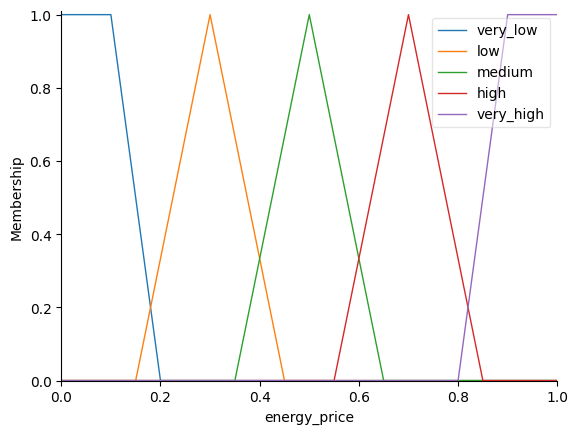

In [ ]:
#Define fuzzy input variable
energy_price = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'energy_price')

#Define fuzzy membership functions
energy_price['very_low'] = fuzz.trapmf(energy_price.universe, [0.0, 0.0, 0.10, 0.20])
energy_price['low'] = fuzz.trimf(energy_price.universe, [0.15, 0.30, 0.45])
energy_price['medium'] = fuzz.trimf(energy_price.universe, [0.35, 0.50, 0.65])
energy_price['high'] = fuzz.trimf(energy_price.universe, [0.55, 0.70, 0.85])
energy_price['very_high'] = fuzz.trapmf(energy_price.universe, [0.80, 0.90, 1.0, 1.0])


energy_price.view()
plt.show()


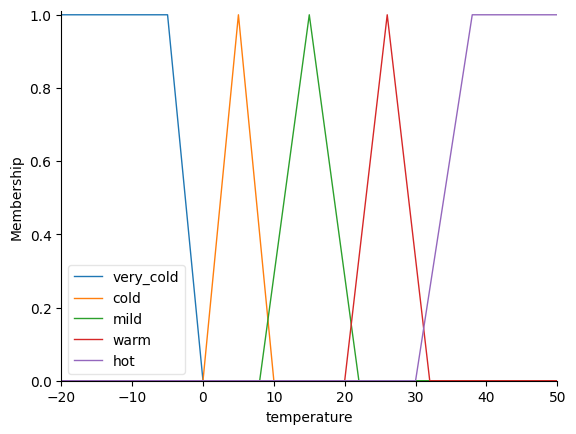

In [ ]:
temperature = ctrl.Antecedent(np.arange(-20, 51, 1), 'temperature')

temperature['very_cold'] = fuzz.trapmf(temperature.universe, [-20, -20, -5, 0])
temperature['cold'] = fuzz.trimf(temperature.universe, [0, 5, 10])
temperature['mild'] = fuzz.trimf(temperature.universe, [8, 15, 22])
temperature['warm'] = fuzz.trimf(temperature.universe, [20, 26, 32])
temperature['hot'] = fuzz.trapmf(temperature.universe, [30, 38, 50, 50])


temperature.view()
plt.show()


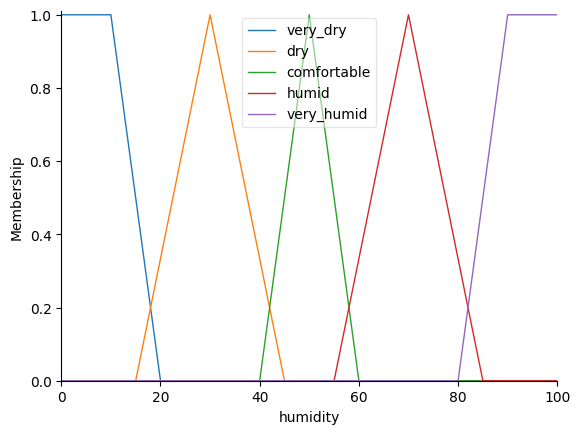

In [22]:
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')

humidity['very_dry'] = fuzz.trapmf(humidity.universe, [0, 0, 10, 20])
humidity['dry'] = fuzz.trimf(humidity.universe, [15, 30, 45])
humidity['comfortable'] = fuzz.trimf(humidity.universe, [40, 50, 60])
humidity['humid'] = fuzz.trimf(humidity.universe, [55, 70, 85])
humidity['very_humid'] = fuzz.trapmf(humidity.universe, [80, 90, 100, 100])

humidity.view()
plt.show()



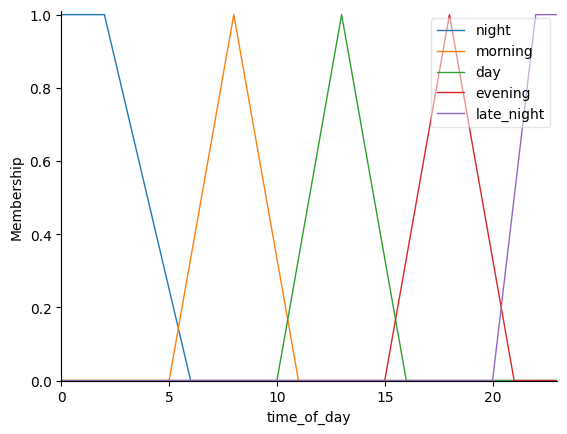

In [23]:
time_of_day = ctrl.Antecedent(np.arange(0, 24, 1), 'time_of_day')

time_of_day['night'] = fuzz.trapmf(time_of_day.universe, [0, 0, 2, 6])
time_of_day['morning'] = fuzz.trimf(time_of_day.universe, [5, 8, 11])
time_of_day['day'] = fuzz.trimf(time_of_day.universe, [10, 13, 16])
time_of_day['evening'] = fuzz.trimf(time_of_day.universe, [15, 18, 21])
time_of_day['late_night'] = fuzz.trapmf(time_of_day.universe, [20, 22, 23, 23])

time_of_day.view()
plt.show()


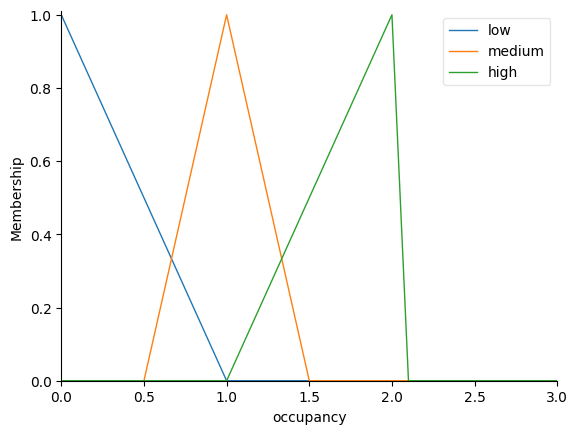

In [24]:

occupancy = ctrl.Antecedent(np.arange(0, 3.1, 0.1), 'occupancy')

occupancy['low'] = fuzz.trimf(occupancy.universe, [0.0, 0.0, 1.0])
occupancy['medium'] = fuzz.trimf(occupancy.universe, [0.5, 1.0, 1.5])
occupancy['high'] = fuzz.trimf(occupancy.universe, [1.0, 2.0, 2.0])


occupancy.view()
plt.show()
